In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn import tree
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import cm

sns.set()

In [2]:
from sklearn.datasets import make_classification

## A data set with 4 features and 4 labels

In [3]:
X, y = make_classification(n_features=4, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=4)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

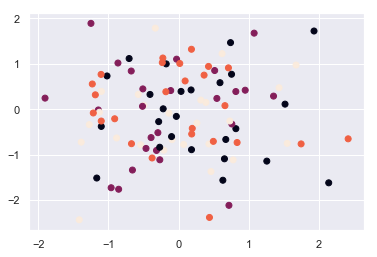

In [5]:
plt.scatter(X[:,0],X[:,1],c=y);

In [6]:
X = pd.DataFrame(data = X, columns = [0,1,2,3])

In [ ]:
X

In [ ]:
y

In [7]:
from collections import Counter
C = Counter(y)
C

Counter({2: 25, 0: 25, 1: 25, 3: 25})

In [8]:
C.most_common()

[(2, 25), (0, 25), (1, 25), (3, 25)]

In [9]:
C.most_common()[0][0]

2

In [11]:
total = len(y)

In [12]:
frequencies = { k:v/total for (k,v) in C.items()}
frequencies

{2: 0.25, 0: 0.25, 1: 0.25, 3: 0.25}

In [13]:
frequencies.values()

dict_values([0.25, 0.25, 0.25, 0.25])

In [14]:
gini_index = np.sum([ p * (1 - p) for p in frequencies.values()])
gini_index

0.75

## Data set with 2 features and 4 labels

In [38]:
Z, u = make_classification(n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1, n_classes=4)

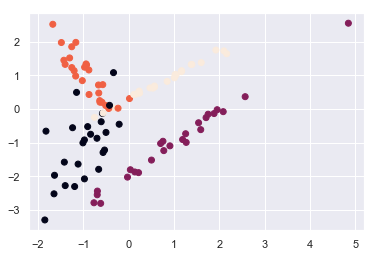

In [39]:
plt.scatter(Z[:,0],Z[:,1],c=u);

In [40]:
Z = pd.DataFrame(data = Z, columns = [0,1])

## Date set from the Visualization Notebook

In [ ]:
n = 1000
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
target = norm.pdf((x - 0.75) / 0.1) + norm.pdf((y - 0.75) / 0.1) \
        + norm.pdf((x - 0.25) / 0.1) + norm.pdf((y - 0.25) / 0.1) \
        + np.array(np.round(np.random.normal(-0.1,0.1, n), 2))

In [ ]:
a = plt.hist(target,bins=20)[1]

In [ ]:
def f(x):
    for i in range(len(a)):
        if x <= a[i]:
            return i
        else:
            continue   

In [ ]:
labels = np.array([f(x) for x in target])

In [ ]:
data1 = pd.DataFrame({'x' : x, 'y' : y})

## The RandomForests is an ensemble of Trees. Each Tree is built up of Nodes.

### Node Class

In [15]:
class Node():
        def __init__(self,data = None,labels=None,min_samples_leaf = 1):
            self.data = data
            self.labels = labels
            self.left = None
            self.right = None
            self.split = None
            self.max_features = 1.0
            self.min_samples_leaf = min_samples_leaf
            if len(self.data) < 2 * self.min_samples_leaf:
                self.isLeaf = True
            else: self.isLeaf = False
            
        def gini_index(self,labels):

            C = Counter(labels)
            total = len(labels)
            frequencies = { k:v/total for (k,v) in C.items()}
            gini_index = np.sum([p*(1-p) for p in frequencies.values()])
            return gini_index
        
        def find_best_split(self):
            
            if len(self.data) < 2*self.min_samples_leaf:
                self.isLeaf = True
                return
        
            data_set = self.data
            labels = self.labels
            features = np.random.choice(data_set.columns,
                                        int(self.max_features * len(data_set.columns)),
                                        replace=False)

            best_split = np.inf
        
            best_feature = None
            best_value = None
        
            for f in features:
            
                for x in data_set[f]:
                
                
                    L_idxs = data_set.index[data_set[f] < x].tolist()
                    R_idxs = data_set.index[data_set[f] >= x].tolist()


                    L_labels = labels[L_idxs]
                    R_labels = labels[R_idxs]
                    
                    if (len(L_labels) < self.min_samples_leaf) or (len(R_labels) < self.min_samples_leaf):
                        continue
                        
                    else:

                        gi_L = self.gini_index(L_labels)
                        gi_R = self.gini_index(R_labels)

                        gini_index_of_split = len(L_idxs) * gi_L + len(R_idxs) * gi_R
               
                        if gini_index_of_split < best_split:
                            best_split = gini_index_of_split
                        
                            self.left = Node(data=data_set.iloc[L_idxs].reset_index(drop=True),
                                             labels = L_labels,min_samples_leaf = self.min_samples_leaf)
                
                            if (gi_L == 0) or (len(L_labels) < 2 * self.min_samples_leaf):
                                    self.left.isLeaf = True

                

                            self.right = Node(data = data_set.iloc[R_idxs].reset_index(drop=True),
                                              labels = R_labels,min_samples_leaf = self.min_samples_leaf)
                    
                            if (gi_R == 0) or (len(L_labels) < 2 * self.min_samples_leaf):
                                       self.right.isLeaf = True

                                
                            best_feature = f
                            best_value = x
                        
                            self.split = (best_feature,best_value)
                                
                        else: continue
  
                return
                                

### Tree class

In [61]:
class Tree():
    
    def __init__(self,root,max_depth = np.inf,min_samples_leaf=1):
        self.root = root
        self.nodes = [[self.root]]
        self.max_depth = max_depth
        self.splits = []
        self.min_samples_leaf = min_samples_leaf
        self.root.min_samples_leaf = self.min_samples_leaf
        
        self.build_tree()
        
        
    def build_tree(self):
        
                while np.any([((n != None) and (not n.isLeaf)) for n in self.nodes[-1]]) and (len(self.nodes) < self.max_depth):

                    level = []
                    
                    for node in self.nodes[-1]:

                        if (node != None) and (not node.isLeaf):

                            node.find_best_split()
                            level.append(node.left)
                            level.append(node.right)
                            self.splits.append(node.split)
                        
                        else: continue
                            
                    if (len(level)==0):
                            return
                    else:
                            self.nodes.append(level) 

        
    def predict(self,x):
                      
        idx = 0
        depth = len(self.nodes)
        
        val = Counter(self.root.labels).most_common()[0][0]
        
        
        
        for i in range(depth):

                node = self.nodes[i][idx]

                if (node.split != None):
                
                    s = node.split
  
                    if (x[s[0]] < s[1]):
#                         if node.left in self.nodes[i+1]:
                            idx = self.nodes[i+1].index(node.left)
                            val = Counter(node.left.labels).most_common()[0][0]
                    
                    else:
#                         if node.right in self.nodes[i+1]:
                                idx = self.nodes[i+1].index(node.right)                         
                                val = Counter(node.right.labels).most_common()[0][0]  
                            
                else: return val
                
        return val


                       


## Applying the Tree to the make_classification data set

In [62]:
root = Node(X,y)

In [63]:
tree = Tree(root)

In [64]:
len(tree.nodes)

9

In [65]:
len(tree.nodes[6])

20

In [67]:
tree.nodes[6][9].isLeaf

True

In [68]:
tree.splits

[(0, -0.2829399395649772),
 (1, -0.7830374892937678),
 (1, 0.23707736859255593),
 (2, 0.462992022592976),
 (0, -0.5744950524745994),
 (2, -0.22141050037728705),
 (0, 0.5160018282759582),
 (3, 0.47454328410369184),
 (0, -0.37664955292948105),
 (0, -1.2300291616908725),
 (2, -0.05200708599571491),
 (3, 0.8098973826038516),
 (2, -0.20471603598484212),
 (0, -0.17557223120822926),
 (2, 0.5831210827717234),
 (3, 1.2208837521508347),
 (3, 0.7547315348737014),
 (0, -0.3913692821467049),
 (3, 1.0565249658308908),
 (1, -0.3057281737545708),
 (3, -0.1781397438323531),
 (2, -0.7581292063551768),
 (0, 1.4347199509232014),
 (3, 1.0794293064208014),
 (0, -1.1020242541095884),
 (2, 0.3432531931834253),
 (0, -0.4067319072149029),
 (3, 0.9544163667972854),
 (2, -0.9854827646908577),
 (2, -0.7885039585722702),
 (3, 1.7898841854686522),
 (0, 0.591875698230369),
 (0, 0.7122210226293089),
 (2, 2.424565245456924),
 (2, 0.25571833133333877),
 (1, 0.4468280520345745),
 (3, 1.0150659955915244),
 (1, 0.840741113

In [69]:
x = X.iloc[30].values

In [70]:
x

array([ 0.65551171, -1.09283649, -0.98432888, -0.89738884])

In [71]:
tree.predict(x)

0

In [72]:
y[30]

0

### RandomForestClassifier class

In [35]:
class RandomForestClassifier():
    
    def __init__(self,n_estimators=10,max_features=1.0,min_samples_leaf=1,bootstrap=False,max_depth = np.inf,
                 random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.bootstrap = bootstrap
        if random_state is not None:
            np.random.seed(random_state)
        self.trees = []  
        
    def fit(self,data,labels):
        
        N = len(labels)
        
        for i in range(self.n_estimators):
            if self.bootstrap:
                idxs = np.random.choice(range(N),N)
                data_set = data.iloc[idxs]
                label_set = labels[idxs]
            else:
                data_set = data
                label_set = labels
                
            root = Node(data_set,label_set)
            root.max_features = self.max_features
            t = Tree(root,self.max_depth,self.min_samples_leaf)
            
            self.trees.append(t)
            
    def predict(self,data_points):
            
            if len(self.trees) == 0:
                print('Classifier needs to be fitted')
                return
            
            preds = []
            for x in data_points:

                x_preds = []
                for t in self.trees:
                    x_preds.append(t.predict(x))
                    
                preds.append(Counter(x_preds).most_common()[0][0])
                
            return preds
                
                
        
            
    

## RandomForestClassifier applied to the 2-dim make_classification data set

In [73]:
rf_clf = RandomForestClassifier(n_estimators=15,max_features=0.5,bootstrap=True,min_samples_leaf=5)

In [74]:
rf_clf.fit(Z,u)

In [75]:
pred = rf_clf.predict(Z.values)

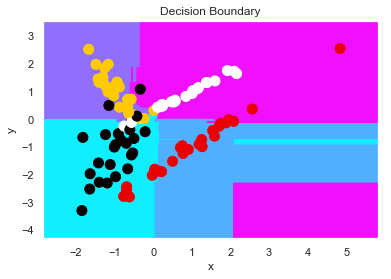

In [76]:
plot_decision_boundary(Z.values,u,rf_clf)

In [77]:
len(u[u == pred])/len(Z)

0.82

In [98]:
rf_clf = RandomForestClassifier(n_estimators=100,bootstrap=True,max_features=0.5,random_state=123)

In [99]:
rf_clf.fit(Z,u)

In [100]:
preds = rf_clf.predict(Z.values)

In [101]:
len(u[u == preds])/len(Z.values)

0.98

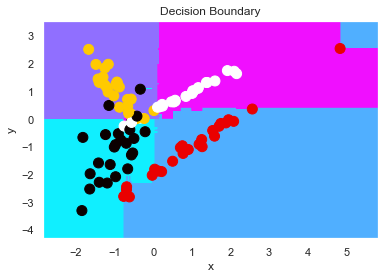

In [102]:
plot_decision_boundary(Z.values,u,rf_clf)

In [44]:
def plot_decision_boundary(data,labels,clf):
    plot_step = 0.02
    x_min, x_max = data[:,0].min() -1, data[:,0].max() + 1
    y_min,y_max = data[:,1].min() -1 , data[:,1].max() + 1

    xx,yy = np.meshgrid(np.arange(x_min,x_max,plot_step),
                   np.arange(y_min,y_max,plot_step))
    Z = np.array(clf.predict(np.c_[xx.ravel(),yy.ravel()]))
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx,yy,Z,cmap='cool')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Decision Boundary')

    plt.scatter(data[:,0],data[:,1],c=labels,cmap='hot',s=100)
    plt.show()